# Cyft Data Investigation

Goal:


#### Description:

_30-Day All-Cause Hospital Readmissions_ is a quality measure that many healthcare organizations use to track their performance. Lower readmission rates indicate better patient outcomes, while higher ones tend to indicate system problems that are negatively impacting patients. The goal of this exercise is to analyze a dataset that simulates hospitalizations for a geriatric patient population in 2015 and 2016 to predict __if a patient is likely to have a readmission based on the information available at the time of their initial admission.__

You have 3 hours to complete the exercise. If you don't get through all the objectives, that's OK. After 3 hours, please finish what you're working on and send in whatever code, analyses, and visualizations (such as images) you have available. Include comments documenting any assumptions you've made as well as other ideas you would have tried if you had more time.

Feel free to use the language and statistical/machine learning libraries that you are most comfortable with, and ask questions along the way if any clarifications are necessary.

In [726]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [727]:
admit = pd.read_csv('../Cyft/readmissions/admissions.csv')
claims = pd.read_csv('../Cyft/readmissions/claims.csv')

#### Data Dictionary

  * admissions.csv
    * Patient - a unique patient identifier string.
    * AdmitDate - start date of hospital admission (yyyy-MM-dd formatted).
    * LOS - length of hospital stay for the admission in days.

  * claims.csv
    * Patient - a unique patient identifier string.
    * AdmitDate - start date of hospital admission (yyyy-MM-dd formatted).
    * Age - patient's current age at time of admission.
    * Gender - single character gender value for the patient (limited to 2 values for simplicity).
    * PrimaryDx - the primary diagnosis code for the patient.
    * Dx2 - the secondary diagnosis code for the patient (nullable).
    * Dx3 - the tertiary diagnosis code for the patient (nullable).
    * PastPCPVisits - the count of primary care physician visits the patient had in the 12 months prior to admission.

In [728]:
admit.head()

,Patient,AdmitDate,LOS
0,5e982461-47d7-4ae9-ac75-d1f31acaee81,2015-09-12,9
1,61e049c2-08e8-469a-a1e0-808d99c084fd,2015-03-23,7
2,19bccbe8-0bc7-4dd5-8066-de5bd76acdff,2015-11-07,7
3,520d5129-fa07-45a3-9108-f6fa895c0169,2015-01-24,7
4,e7af2ac0-bd25-4cfe-a6f2-e6642db02f64,2015-09-08,5


In [729]:
claims.head()

,Patient,AdmitDate,Age,Gender,PrimaryDx,Dx2,Dx3,PastPCPVisits
0,5e982461-47d7-4ae9-ac75-d1f31acaee81,2015-09-12,74,M,N18,T88,NaN,19
1,61e049c2-08e8-469a-a1e0-808d99c084fd,2015-03-23,71,F,N18,R39,@NA,3
2,19bccbe8-0bc7-4dd5-8066-de5bd76acdff,2015-11-07,85,M,E11,R39,NaN,10
3,520d5129-fa07-45a3-9108-f6fa895c0169,2015-01-24,67,F,N18,F05,NaN,8
4,e7af2ac0-bd25-4cfe-a6f2-e6642db02f64,2015-09-08,78,F,A41,T88,J18,13


#### Initial Look

There are two overlapping columns, patient ID and admitdate. The csvs map 1:1. AdmitDate will be more useful converted to a datetime type. 

In [730]:
print('admit: {} rows and {} columns'.format(*admit.shape))
print('claims: {} rows and {} columns'.format(*claims.shape))

admit: 5849 rows and 3 columns
claims: 5849 rows and 8 columns


In [731]:
full = pd.merge(admit,claims,on=['Patient','AdmitDate'])
full['AdmitDate'] = pd.to_datetime(full['AdmitDate'])
full.head()

,Patient,AdmitDate,LOS,Age,Gender,PrimaryDx,Dx2,Dx3,PastPCPVisits
0,5e982461-47d7-4ae9-ac75-d1f31acaee81,2015-09-12,9,74,M,N18,T88,NaN,19
1,61e049c2-08e8-469a-a1e0-808d99c084fd,2015-03-23,7,71,F,N18,R39,@NA,3
2,19bccbe8-0bc7-4dd5-8066-de5bd76acdff,2015-11-07,7,85,M,E11,R39,NaN,10
3,520d5129-fa07-45a3-9108-f6fa895c0169,2015-01-24,7,67,F,N18,F05,NaN,8
4,e7af2ac0-bd25-4cfe-a6f2-e6642db02f64,2015-09-08,5,78,F,A41,T88,J18,13


In [732]:
print('full: {} rows and {} columns'.format(*full.shape))

full: 5849 rows and 9 columns


In [733]:
#full.set_index('AdmitDate')

#### Null Values

Can be:
    
    empty strings or values
    NaN
    @NA

In [734]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5849 entries, 0 to 5848
Data columns (total 9 columns):
Patient          5849 non-null object
AdmitDate        5849 non-null datetime64[ns]
LOS              5849 non-null int64
Age              5849 non-null int64
Gender           5849 non-null object
PrimaryDx        5849 non-null object
Dx2              5849 non-null object
Dx3              3883 non-null object
PastPCPVisits    5849 non-null int64
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 457.0+ KB


In [735]:
full_nan = full.replace('@NA',np.NaN) # replace @NA
full_nan = full_nan.replace('',np.NaN) # didn't find any empty strings

Looks like feature Dx3 is the only one with null values but they are 67% of the column which makes it unrealistic to impute. 

This makes sense as it is less likely to have a third diagnosis at admission time as a primary or secondary. Have to keep an eye on it down the line. For now leave as ''

In [736]:
full_nan.isnull().sum() / full_nan.shape[0]

Patient          0.00000
AdmitDate        0.00000
LOS              0.00000
Age              0.00000
Gender           0.00000
PrimaryDx        0.00000
Dx2              0.00000
Dx3              0.66849
PastPCPVisits    0.00000
dtype: float64

In [737]:
full = full.replace('@NA',np.NaN) # replace @NA
full = full.replace('',np.NaN) # didn't find any empty strings
full = full.replace(np.NaN,'')

In [738]:
for col in full.columns:
    print(full[col].value_counts())

be78ad19-b6a6-409c-9b8f-4720a6fa31f3    2
2773eed9-c059-47af-b7aa-d21954327227    2
5494b3ff-c67d-415e-8ee5-7979ca6b7ea4    2
5ad38480-7320-4437-aa95-4155e62b1b70    2
deb63588-daa4-4b97-ac12-fc1be6d8f83c    2
54f2cdbf-669f-488a-8868-55a24bbfe197    2
1730ee80-e9d0-4702-a4c4-80efdc8cec2e    2
1a34bbbc-1f57-41b6-9604-e9d855ba7e98    2
67b3a488-fc7f-47ed-8cfa-6669aa799a6d    2
d6c1b3c8-ee33-449b-afc4-6c96c6a40b36    2
2eb136a7-5bbf-4806-9a2a-63bad6f1aa67    2
02df8468-986a-4388-b90c-347e2a1ce98e    2
8adec5fb-959b-49b6-ac41-7a7fe5a5f2f6    2
55c3f958-3303-4c42-b7e2-b96ebc23c3b6    2
b22e51b9-2432-41dd-ac36-547f6f418727    2
fba08ad7-9f45-4f48-a1be-9d3dc923b773    2
851b3330-c447-4fb0-8d93-6da136cf8ffb    2
1acc036c-b3eb-4994-a5ca-adc0a70fdfdf    2
36d257df-a53b-4b92-a99d-97698c7f1d50    2
96b6772d-a4a0-47c6-bfdd-887cbd623de9    2
347fe701-f9a8-4db4-806c-cb772c5657cd    2
1c0665a0-9887-4544-b50a-77561e271a39    2
f7cc4dfd-c025-4692-9d0a-81e13eb7a8d0    2
3809c6eb-ad6a-4840-84f8-00d14fe62d

#### Determine Patients with Readmissions

Any patient id which shows up more than once is considered a readmission. New binary column is created since this is our target variable.

In [739]:
print('There are {} patients readmitted in the 30 day window'.format(np.sum(full['Patient'].value_counts()>1)))


There are 1932 patients readmitted in the 30 day window


In [740]:
full['Readmitted'] = full.groupby(['Patient'])['Patient'].transform('count')
full['Readmitted'] = full['Readmitted'].map({2:1,1:0})

In [741]:
full[full['Readmitted'] == 1].groupby(['Patient']).diff()['AdmitDate'].tail()

5844    6 days
5845   31 days
5846   40 days
5847   36 days
5848   32 days
Name: AdmitDate, dtype: timedelta64[ns]

In [742]:
full['DaysSinceAdmission'] = full[full['Readmitted'] == 1].groupby(['Patient']).diff()['AdmitDate']

In [743]:
full['<=30Days'] = (full['DaysSinceAdmission'] <= pd.Timedelta('30 days')).astype(np.int)

In [744]:
full.tail()

,Patient,AdmitDate,LOS,Age,Gender,PrimaryDx,Dx2,Dx3,PastPCPVisits,Readmitted,DaysSinceAdmission,<=30Days
5844,641acfac-9bd1-4864-be0a-52d4bfc78ef9,2016-03-14,7,75,M,A41,I51,,15,1,6 days,1
5845,e152df3f-69a5-4ad4-9cf0-a3b7a6b9d4d8,2016-12-20,5,86,M,E11,R41,,17,1,31 days,0
5846,a45e1bab-df5f-4078-b938-31f920e2f765,2016-09-18,9,78,M,A41,I51,R05,14,1,40 days,0
5847,963fdb5d-bfe6-47c9-84c8-6456ce0fd093,2017-01-19,6,81,M,J44,F05,,17,1,36 days,0
5848,a2940e72-8185-4944-8257-6c440d8aa374,2016-09-11,8,77,F,I50,R39,,11,1,32 days,0


#### Believe I was going about this the wrong way

I was looking at the characteristics of the _readmission_ trying to predict itself when I should have flagged the first visit as __will_be_readmitted__ to use its characteristics to predict a readmission

In [745]:
full[['WillBe<=30Days']] = full[full['Readmitted'] == 1].groupby('Patient').shift(-1)[['<=30Days']].fillna(0).astype(np.int)


Quick spot check to cofirm thats correct

In [746]:
full[full['Patient'] == '5e982461-47d7-4ae9-ac75-d1f31acaee81']

,Patient,AdmitDate,LOS,Age,Gender,PrimaryDx,Dx2,Dx3,PastPCPVisits,Readmitted,DaysSinceAdmission,<=30Days,WillBe<=30Days
0,5e982461-47d7-4ae9-ac75-d1f31acaee81,2015-09-12,9,74,M,N18,T88,,19,1,NaT,0,1.0
4304,5e982461-47d7-4ae9-ac75-d1f31acaee81,2015-09-22,5,74,M,J44,R41,H91,21,1,10 days,1,0.0


In [747]:
full['<=30Days'].value_counts()#.mean()

0    4471
1    1378
Name: <=30Days, dtype: int64

In [748]:
full['WillBe<=30Days'].value_counts()#.mean()

0.0    2486
1.0    1378
Name: WillBe<=30Days, dtype: int64

The means were different indicating something was wrong. Needed to fill rest of the column with 0's. 

In [749]:
full['WillBe<=30Days'] = full['WillBe<=30Days'].fillna(0)

In [750]:
print('There is a {:.2f}% chance of being readmitted within 30 days'.format(100*full['WillBe<=30Days'].mean()))


There is a 23.56% chance of being readmitted within 30 days


#### Modification

Since the rest of the notebook uses '<=30Days' as the target, I'm going to overwrite it with 'WillBe<=30Days'

In [751]:
full['<=30Days'] = full['WillBe<=30Days']
full.drop('WillBe<=30Days',axis=1,inplace=True)

#### Summary statistics of features

Confirm no duplicates. Would not want to be incorrectly counting.

In [752]:
full.duplicated().sum()

0

In [753]:
print('Columns:\n\t'+'\n\t'.join(map(str,[col for col in full.columns])))

Columns:
	Patient
	AdmitDate
	LOS
	Age
	Gender
	PrimaryDx
	Dx2
	Dx3
	PastPCPVisits
	Readmitted
	DaysSinceAdmission
	<=30Days


Theres a uniform distribution in of data across all the dates in the dataset with the months in 2017 trailing off.

2017 dates won't be used in the evaluation of the model so this will not affect us

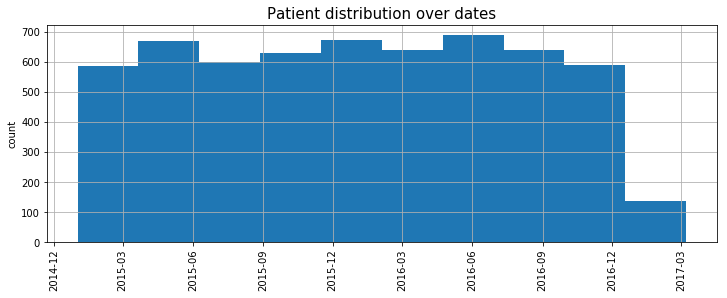

In [754]:
full['AdmitDate'].hist(xrot=90,figsize=(12,4))
plt.title('Patient distribution over dates',size=15)
plt.ylabel('count')

There is a ~normal distribution of Length of Stay centered around 6 days. There is a broad spread with a min of 1 and a max of 15 however 50% of the data sits in buckets days 5,6,7 days long.

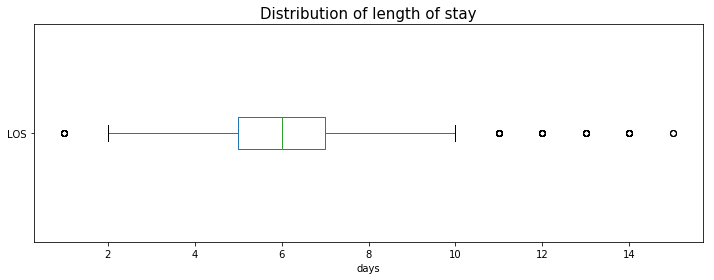

In [755]:
full['LOS'].plot(kind='box',figsize=(12,4),vert=False)
plt.xlabel('days')
plt.title('Distribution of length of stay',size=15)

In [756]:
full['LOS'].unique().shape[0]

15

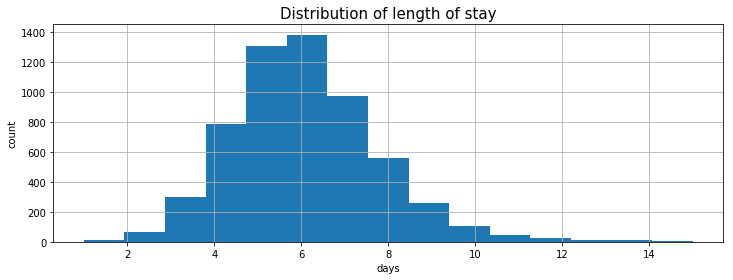

In [757]:
full['LOS'].hist(bins=15,figsize=(12,4))
plt.title('Distribution of length of stay',size=15)
plt.xlabel('days')
plt.ylabel('count')

Age is a normal distribution with a clipping at the end probably rounding ages over 90 to the age 90. Majority sit between 72-80 yrs old.

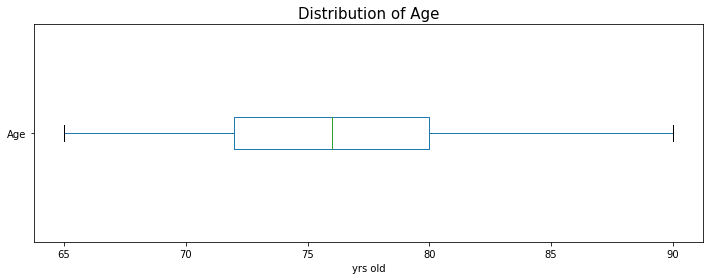

In [758]:
full['Age'].plot(kind='box',figsize=(12,4),vert=False)
plt.xlabel('yrs old')
plt.title('Distribution of Age',size=15)

In [759]:
full['Age'].unique().shape[0]

26

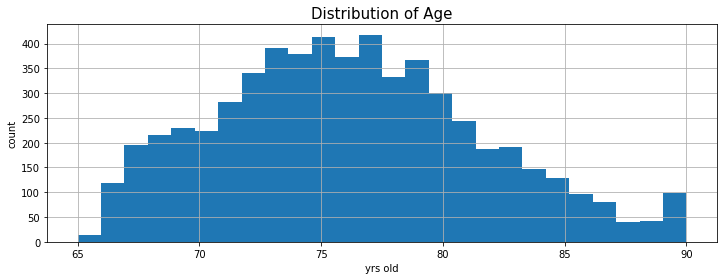

In [760]:
full['Age'].hist(bins=26,figsize=(12,4))
plt.title('Distribution of Age',size=15)
plt.xlabel('yrs old')
plt.ylabel('count')

Even split of genders, though slightly more female as would be expected by their long expected lifespan

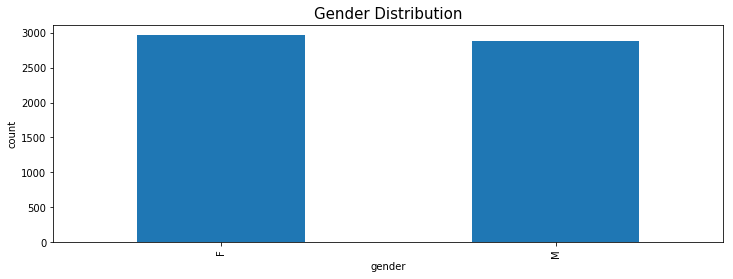

In [761]:
full['Gender'].value_counts().plot(kind='bar',figsize=(12,4))
plt.title('Gender Distribution',size=15)
plt.xlabel('gender')
plt.ylabel('count')

There are 3 diagnoses columns so lets take a look at all together. 

PrimaryDx:
    - N39 has very few occurances
    
Dx2:
    - M54 has very few occurances
    
Dx3:
    - Exluding the missing data, all Dxs look to have between 200-500 occurances


In [762]:
Dx_cols = ['PrimaryDx','Dx2','Dx3']

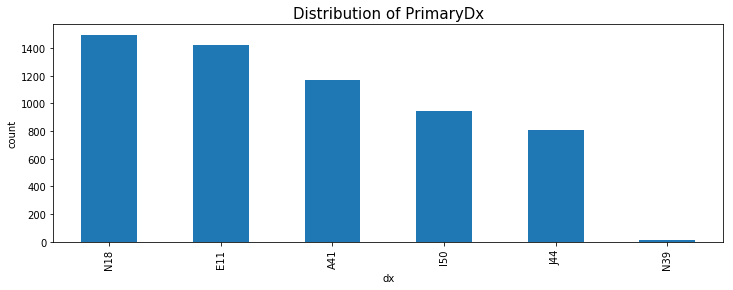

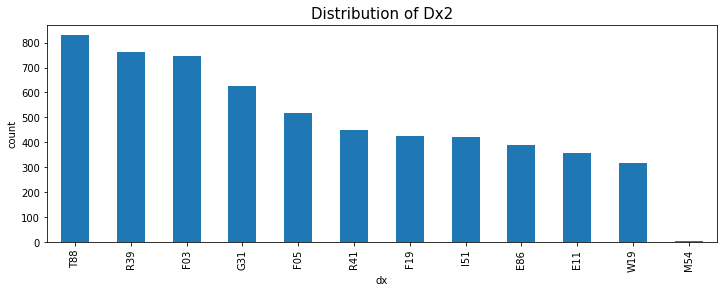

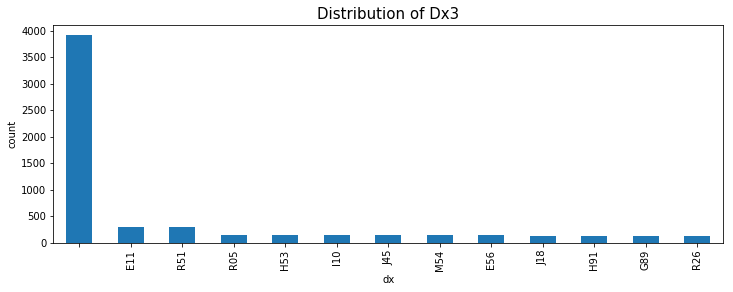

In [763]:
for col in Dx_cols:
    bins = full[col].unique().shape[0]
    #full[col].hist(bins=bins,figsize=(12,4))
    full[col].value_counts().plot(kind='bar',figsize=(12,4))
    plt.title('Distribution of {}'.format(col),size=15)
    plt.xlabel('dx')
    plt.ylabel('count')
    plt.figure()

Past visits are all centered around 11 with 50% of the data between 7 adn 15 visits.

In [764]:
full['PastPCPVisits'].describe()

count    5849.000000
mean       11.123782
std         5.373314
min         1.000000
25%         7.000000
50%        11.000000
75%        15.000000
max        34.000000
Name: PastPCPVisits, dtype: float64

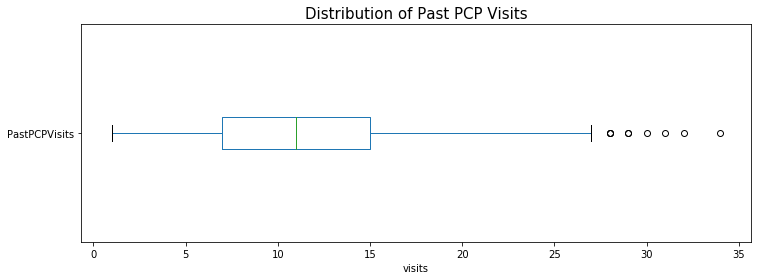

In [765]:
full['PastPCPVisits'].plot(kind='box',figsize=(12,4),vert=False)
plt.xlabel('visits')
plt.title('Distribution of Past PCP Visits',size=15)

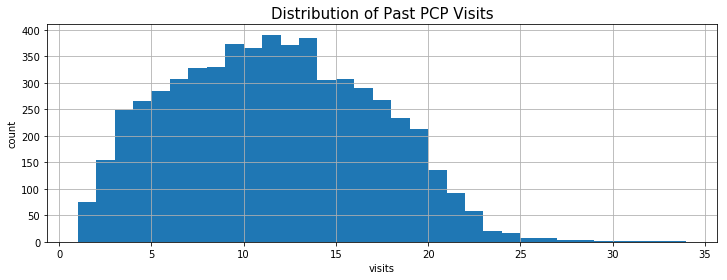

In [766]:
bins = full['PastPCPVisits'].unique().shape[0]
full['PastPCPVisits'].hist(bins=bins,figsize=(12,4))
plt.title('Distribution of Past PCP Visits'.format(col),size=15)
plt.xlabel('visits')
plt.ylabel('count')
plt.figure()

#### Take a quick look at which diagnoses, ages, and past visits lead to the highest readmittance

Baseline rate is 66% readmitted but only 24% of those are readmitted within less than 30 days. We are therefore looking for combinations which lead to a higher readmitted rate than 24%.

In [767]:
full['<=30Days'].mean()

0.23559582834672593

In [768]:
full.groupby(['PrimaryDx'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'}).sort_values(by='mean',ascending=False)


/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,sum,count,mean
PrimaryDx,,,
N39,6.0,10,0.600000
E11,503.0,1422,0.353727
N18,504.0,1498,0.336449
A41,260.0,1171,0.222032
I50,84.0,943,0.089077
J44,21.0,805,0.026087


In [769]:
full.groupby(['Dx2'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'}).sort_values(by='mean',ascending=False)

/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,sum,count,mean
Dx2,,,
M54,4.0,5,0.800000
T88,348.0,830,0.419277
F03,288.0,748,0.385027
R39,271.0,764,0.354712
G31,182.0,626,0.290735
F05,126.0,517,0.243714
R41,78.0,448,0.174107
F19,41.0,425,0.096471
I51,20.0,423,0.047281


In [770]:
full.groupby(['Dx3'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'}).sort_values(by='mean',ascending=False)


/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,sum,count,mean
Dx3,,,
I10,45.0,144,0.312500
R51,74.0,287,0.257840
E11,77.0,299,0.257525
J18,33.0,132,0.250000
H91,32.0,129,0.248062
,915.0,3910,0.234015
G89,29.0,125,0.232000
J45,31.0,136,0.227941
R05,32.0,147,0.217687


Age:
    - There is a sharp drop off in readmittance rate in the low to mid 70s
    - Late 70s and onward there is a 6% higher chance that you'll be readmitted

/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


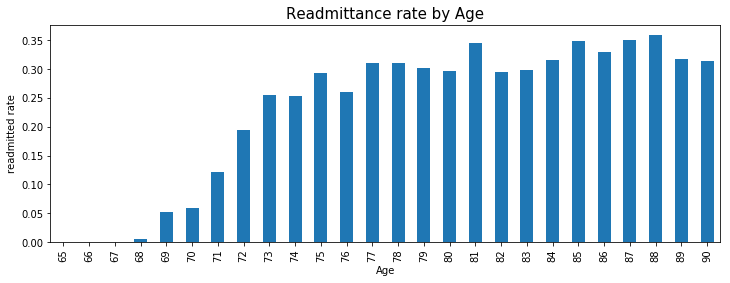

In [771]:
full.groupby(['Age'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'})['mean'].plot(kind='bar',figsize=(12,4))
plt.title('Readmittance rate by Age',size=15)
plt.ylabel('readmitted rate')

In [772]:
full.groupby(['Age'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'}).sort_values(by='mean',ascending=False)

/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,sum,count,mean
Age,,,
88,14.0,39,0.358974
87,28.0,80,0.350000
85,45.0,129,0.348837
81,84.0,244,0.344262
86,32.0,97,0.329897
89,13.0,41,0.317073
84,46.0,146,0.315068
90,31.0,99,0.313131
77,130.0,418,0.311005


In [773]:
full.groupby(['PastPCPVisits'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'}).sort_values(by='mean',ascending=False)


/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,sum,count,mean
PastPCPVisits,,,
30,1.0,1,1.000000
11,125.0,391,0.319693
1,23.0,75,0.306667
13,110.0,385,0.285714
8,90.0,330,0.272727
10,98.0,366,0.267760
17,70.0,267,0.262172
9,97.0,374,0.259358
7,85.0,328,0.259146


#### Split into Train, Test

There are no variables which look ordinal so create onehot encodings of categorical variables. 

In [774]:
full_orig = full.copy()

In [775]:
full = full.set_index('AdmitDate')

In [776]:
for col in [col for col in full.columns if full[col].dtype == 'object' and 'Patient' not in col]:
    dummies = pd.get_dummies(full[col],prefix=col)
    full.drop(col,axis=1,inplace=True)
    full = pd.concat([full,dummies],axis=1)    

In [777]:
full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5849 entries, 2015-09-12 to 2016-09-11
Data columns (total 40 columns):
Patient               5849 non-null object
LOS                   5849 non-null int64
Age                   5849 non-null int64
PastPCPVisits         5849 non-null int64
Readmitted            5849 non-null int64
DaysSinceAdmission    1932 non-null timedelta64[ns]
<=30Days              5849 non-null float64
Gender_F              5849 non-null uint8
Gender_M              5849 non-null uint8
PrimaryDx_A41         5849 non-null uint8
PrimaryDx_E11         5849 non-null uint8
PrimaryDx_I50         5849 non-null uint8
PrimaryDx_J44         5849 non-null uint8
PrimaryDx_N18         5849 non-null uint8
PrimaryDx_N39         5849 non-null uint8
Dx2_E11               5849 non-null uint8
Dx2_E86               5849 non-null uint8
Dx2_F03               5849 non-null uint8
Dx2_F05               5849 non-null uint8
Dx2_F19               5849 non-null uint8
Dx2_G31               

In [778]:
train = full['2015']
test = full['2016']

In [779]:
print('train: {} rows and {} columns'.format(*train.shape))
print('test: {} rows and {} columns'.format(*test.shape))

train: 2856 rows and 40 columns
test: 2938 rows and 40 columns


In [780]:
#[col for col in train.columns]

In [781]:
X_train = train.drop(['Patient','Readmitted','DaysSinceAdmission','<=30Days'],axis=1)
y_train = train['<=30Days']
X_test = test.drop(['Patient','Readmitted','DaysSinceAdmission','<=30Days'],axis=1)
y_test = test['<=30Days']

#### Model

This is a binary classification problem so usually start with a simple logistic regression model. I'm going to use the f1_score which is a mixture of precision and recall to evaluate which model does better. This will lead to a more stable classifier than using accuracy or precision or recall alone. 

In fact the accuracy of the logistic regression is slightly higher than the random forest however its f1_score is more desireable.

In [782]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.cross_validation import cross_val_score

In [783]:
def accuracy(true,pred):
    correct = 0
    pred_len = len(pred)
    for i in range(pred_len):
        if pred[i] == true[i]:
            correct += 1
    return correct/pred_len

In [784]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

In [785]:
confusion_matrix(y_test,lr_pred)

array([[2085,  174],
       [ 425,  254]])

In [786]:
f1_score(y_test,lr_pred)

0.45889792231255649

In [787]:
accuracy(y_test,lr_pred)

0.7961198093941457

In [788]:
cross_val_score(lr,X_train,y_train,cv=10).mean()

0.78330218706423305

In [789]:
rf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

In [790]:
confusion_matrix(y_test,rf_pred)

array([[2067,  192],
       [ 456,  223]])

In [791]:
f1_score(y_test,rf_pred)

0.40767824497257765

In [792]:
accuracy(y_test,rf_pred)

0.7794417971409122

In [793]:
cross_val_score(rf,X_train,y_train,cv=10).mean()

0.77522340644282828

#### Continuing on

If I had more time, I would dive more into my investigation of the features and do some feature engineering. 

I'd also run the models through a gridsearch and correctly approximate their performance using crossvalidation and try an SVM or neural net as well. 

When I created a few of these models I would be able to evaluate which performed better for different samples by analyzing their errors and then stack them in an ensemble.

#### Quick look at feature importance based on the models

logistic regression coefs give us an understanding of how the decision boundary is drawn

random forest feature importance is a similar metric which gauges how important the features are to each tree in the forest

There are a couple features common between these measures:

    Age
    PastPCPVisits

In [794]:
lr_coefs = pd.DataFrame(X_train.columns,lr.coef_[0]).reset_index()
lr_coefs.rename(columns={'index':'lr coef',0:'feat'},inplace=True)

In [795]:
lr_coefs.sort_values(by='lr coef',ascending=False).head(10)

,lr coef,feat
21,1.014121,Dx2_T88
13,0.828248,Dx2_F03
19,0.565998,Dx2_R39
14,0.432637,Dx2_F05
16,0.420952,Dx2_G31
18,0.344387,Dx2_M54
0,0.274143,LOS
26,0.106840,Dx3_G89
1,0.051069,Age
35,0.044299,Dx3_R51


In [796]:
rf_imps = pd.DataFrame(X_train.columns,rf.feature_importances_).reset_index()
rf_imps.rename(columns={'index':'rf imp',0:'feat'},inplace=True)

In [797]:
rf_imps.sort_values(by='rf imp',ascending=False).head(10)['feat']

1               Age
2     PastPCPVisits
0               LOS
21          Dx2_T88
8     PrimaryDx_J44
23             Dx3_
13          Dx2_F03
6     PrimaryDx_E11
9     PrimaryDx_N18
3          Gender_F
Name: feat, dtype: object

In [798]:
both_imps = pd.merge(lr_coefs,rf_imps,on=['feat'])

In [799]:
both_imps.sort_values(by='rf imp',ascending=False).head(10)

,lr coef,feat,rf imp
1,0.051069,Age,0.211523
2,0.015135,PastPCPVisits,0.192460
0,0.274143,LOS,0.158566
21,1.014121,Dx2_T88,0.029549
8,-2.210072,PrimaryDx_J44,0.027874
23,-0.313949,Dx3_,0.023410
13,0.828248,Dx2_F03,0.022995
6,-0.089260,PrimaryDx_E11,0.022682
9,-0.085261,PrimaryDx_N18,0.021916
3,-2.110184,Gender_F,0.021334


In [800]:
set(lr_coefs.sort_values(by='lr coef',ascending=False).head(10)['feat']).intersection(rf_imps.sort_values(by='rf imp',ascending=False).head(10)['feat'])


{'Age', 'Dx2_F03', 'Dx2_T88', 'LOS'}

In [801]:
top_feats = list(set().union(rf_imps.sort_values(by='rf imp',ascending=False).head(10)['feat'],lr_coefs.sort_values(by='lr coef',ascending=False).head(10)['feat']))

In [802]:
#Dxs_summarized['F03']

#### Rerun models with Gridsearch

Using original scaled data

In [803]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score, recall_score

In [804]:
# X_train = train[top_feats]
# y_train = train['<=30Days']
# X_test = test[top_feats]
# y_test = test['<=30Days']

In [805]:
X_train = train.drop(['Patient','Readmitted','DaysSinceAdmission','<=30Days'],axis=1)
y_train = train['<=30Days']
X_test = test.drop(['Patient','Readmitted','DaysSinceAdmission','<=30Days'],axis=1)
y_test = test['<=30Days']

In [806]:
ss = StandardScaler()

In [807]:
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

In [808]:
print('Accuracy baseline is: {:.2f}%'.format(100*(1-full['<=30Days'].mean())))


Accuracy baseline is: 76.44%


#### Grid search KNN 

With > 5000 samples I would have expected a high number of neighbors but by decreasing the neighbors and also increasing the p value which manipulates the similarity metric usd to determine which neighbors are most similar to the out of sample pred, knn seems to figure out a better judgement

In [901]:
params = {}
params['n_neighbors'] = [1,2,3,4]#,5,6,7,8]#[i for i in range(5,60,5)]
params['weights'] = ['uniform','distance']
params['p'] = [1,2,3,4]#[5,6,7]#[3,4,5]#

In [902]:
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn,params,scoring='f1')#'f1')

In [903]:
knn_grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [900]:
knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=1,
           weights='uniform')

In [814]:
knn = knn_grid.best_estimator_
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)

In [815]:
confusion_matrix(y_test,knn_pred)

array([[2081,  178],
       [ 516,  163]])

In [816]:
y_pred = knn_pred
print('precision: {:.2f}\nrecall: {:.2f}\naccuracy: {:.2f}'.format(precision_score(y_test,y_pred),
                                                       recall_score(y_test,y_pred),
                                                       accuracy(y_test,y_pred)))

precision: 0.48
recall: 0.24
accuracy: 0.76


#### Gridsearch with RF

Did this a few times with n_estimators @ 200 to get a quick idea. Then settled on a smaller number of params and upped trees

After evaluating more trees, the best performer was still worse than the 200 tree model, so re-search on lower number of trees.

Between f1 of .35 and .36 the scores and params start shuffling around probably due to random choice in sampling.

In [817]:
params = {}
params['criterion'] = ['gini','entropy']
params['n_estimators'] = [200]#[400,600,800]#[200]
params['max_depth'] = [5,10,15,20,25,30,35,40,45,50]#[15,20,25]#[5,10,15]
#params['max_features'] = ['auto'] #['auto','sqrt']
params['min_samples_split'] = [2,4,6,8,10] #[10,20,40]
params['min_samples_leaf'] = [1,2,3]
#params['class_weight'] = ['balanced']

In [818]:
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf,params,scoring='precision')#'f1')

In [819]:
rf_grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [200], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='precision', verbose=0)

In [820]:
rf = rf_grid.best_estimator_
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

In [821]:
confusion_matrix(y_test,rf_pred)

array([[2243,   16],
       [ 657,   22]])

In [822]:
y_pred = rf_pred
print('precision: {:.2f}\nrecall: {:.2f}\naccuracy: {:.2f}'.format(precision_score(y_test,y_pred),
                                                       recall_score(y_test,y_pred),
                                                       accuracy(y_test,y_pred)))

precision: 0.58
recall: 0.03
accuracy: 0.77


#### Logistic Regression

Whats interesting about lr in this case is the large difference in precision and recall when changing the hyperparameter class_weights to 'balanced' which essentially pads an imbalanced class which we kind of have here being ~1/4.

More thought and discussion would need to go into which would be more suitable for the application.

In [824]:
params = {}
params['penalty'] = ['l1','l2']
#params['class_weight'] = ['balanced']
params['C'] = [.001,.01,.1,.5,1,5,10]#[.03,.05,.1]

In [825]:
lr = LogisticRegression()
lr_grid = GridSearchCV(lr,params,scoring='recall')#'f1')

In [826]:
lr_grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=0)

In [827]:
lr_balanced = lr_grid.best_estimator_
lr_balanced.fit(X_train,y_train)
lr_balanced_pred = lr_balanced.predict(X_test)
lr_balanced_predp = lr_balanced.predict_proba(X_test)

In [828]:
confusion_matrix(y_test,lr_balanced_pred)

array([[2032,  227],
       [ 374,  305]])

In [829]:
y_pred = lr_pred
print('precision: {:.2f}\nrecall: {:.2f}\naccuracy: {:.2f}'.format(precision_score(y_test,y_pred),
                                                       recall_score(y_test,y_pred),
                                                       accuracy(y_test,y_pred)))

precision: 0.59
recall: 0.37
accuracy: 0.80


Brief visualization of the predictions. See how to increase difference of spread.

([array([   0.,    1.,   24.,  123.,  384.,  576.,  684.,  656.,  396.,   94.]),
  array([  94.,  396.,  656.,  684.,  576.,  384.,  123.,   24.,    1.,    0.])],
 array([ 0.15097434,  0.22077947,  0.2905846 ,  0.36038974,  0.43019487,
         0.5       ,  0.56980513,  0.63961026,  0.7094154 ,  0.77922053,
         0.84902566]),
 <a list of 2 Lists of Patches objects>)

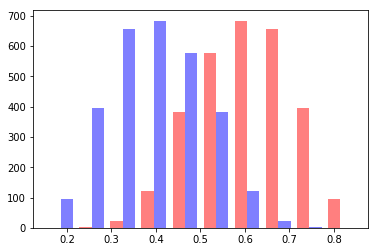

In [836]:
import seaborn as sns
neg_class = pd.DataFrame(lr_balanced_predp)[0]
pos_class = pd.DataFrame(lr_balanced_predp)[1]
plt.hist([neg_class,pos_class], color=['r','b'], alpha=0.5)

#### Naive Bayes



In [830]:
from sklearn import naive_bayes

In [852]:
nb = naive_bayes.GaussianNB()
cv_score = cross_val_score(nb,X_train,y_train,cv=10)

In [853]:
cv_score.mean()

0.59599224842367915

In [857]:
nb.fit(X_train,y_train)
nb_pred = nb.predict_proba(X_test)

In [859]:
confusion_matrix(y_test,nb_pred[:,0])

array([[   0, 2259],
       [   0,  679]])

In [861]:
y_pred = nb_pred[:,0]
print('precision: {:.2f}\nrecall: {:.2f}\naccuracy: {:.2f}'.format(precision_score(y_test,y_pred),
                                                       recall_score(y_test,y_pred),
                                                       accuracy(y_test,y_pred)))

precision: 0.23
recall: 1.00
accuracy: 0.23


#### Types of Errors

In this dataset it seems that having a higher false positive rate would be better than having a false negative rate. 

    False positive - patient is expected to be readmitted, when they will not be. AKA patient is assumed to be sicker than they are.
    
    False negative - patient is not expected to be readmitted, but they will be. AKA patient is sicker than they seem or something unexpected will occur to them between first and second admit.
    

In [862]:
print('{} false positives and {} false negatives'.format(confusion_matrix(y_test,knn_pred)[0,1],confusion_matrix(y_test,knn_pred)[1,0]))


178 false positives and 516 false negatives


#### Precision
A higher precision means lower false positives

    TP / (TP + FP)

#### Recall
A high recall means lower false negatives

    TP / (TP + FN)

#### Examine where each model outperforms the others

Shows a high overlap for rf. lr and knn seem to be different. Perhaps we can figure out what is unique about the cases where each outperforms and perhaps use model stacking to take advantage of this.

In [889]:
preds = pd.DataFrame(y_test)
preds['knn'] = knn_pred
preds['rf'] = rf_pred
preds['lr'] = lr_pred

In [890]:
preds.mean()

<=30Days    0.231110
knn         0.116065
rf          0.012934
lr          0.145677
dtype: float64

In [891]:
knn_mask = ((preds['knn'] == preds['<=30Days']) &
            (preds['rf'] != preds['<=30Days']) &
            (preds['lr'] != preds['<=30Days']))
lr_mask = ((preds['lr'] == preds['<=30Days']) &
            (preds['rf'] != preds['<=30Days']) &
            (preds['knn'] != preds['<=30Days']))
rf_mask = ((preds['rf'] == preds['<=30Days']) &
            (preds['knn'] != preds['<=30Days']) &
            (preds['lr'] != preds['<=30Days']))

In [892]:
preds['knn_outperforms'] = np.where(knn_mask,1,0)
preds['lr_outperforms'] = np.where(lr_mask,1,0)
preds['rf_outperforms'] = np.where(rf_mask,1,0)

In [893]:
knn_mask = ((preds['knn'] != preds['<=30Days']) &
            (preds['rf'] == preds['<=30Days']) &
            (preds['lr'] == preds['<=30Days']))
lr_mask = ((preds['lr'] != preds['<=30Days']) &
            (preds['rf'] == preds['<=30Days']) &
            (preds['knn'] == preds['<=30Days']))
rf_mask = ((preds['rf'] != preds['<=30Days']) &
            (preds['knn'] == preds['<=30Days']) &
            (preds['lr'] == preds['<=30Days']))

In [894]:
preds['knn_underperforms'] = np.where(knn_mask,1,0)
preds['lr_underperforms'] = np.where(lr_mask,1,0)
preds['rf_underperforms'] = np.where(rf_mask,1,0)

In [895]:
preds.mean()

<=30Days             0.231110
knn                  0.116065
rf                   0.012934
lr                   0.145677
knn_outperforms      0.027570
lr_outperforms       0.052076
rf_outperforms       0.020422
knn_underperforms    0.041184
lr_underperforms     0.033356
rf_underperforms     0.026889
dtype: float64

In [868]:
test = full_orig.set_index('AdmitDate')['2016']
X_test = test.drop(['Patient','Readmitted','DaysSinceAdmission','<=30Days'],axis=1)

In [869]:
preds = pd.concat([X_test,preds],axis=1)

#### Outperformance of each model

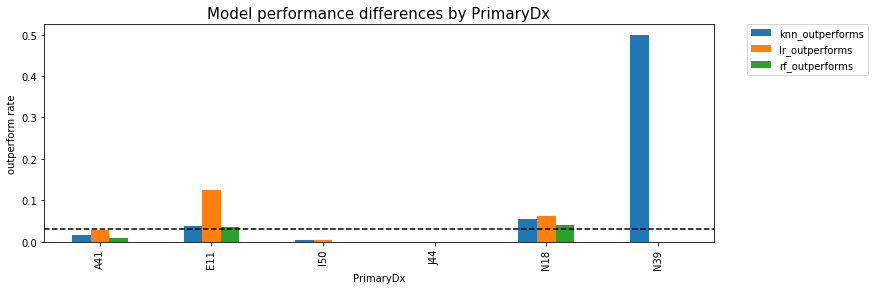

In [870]:
feat1 = 'PrimaryDx'
metrics = ['knn_outperforms','lr_outperforms','rf_outperforms']

knn_avg = preds['knn_outperforms'].mean()
preds.groupby([feat1])[metrics].mean().plot(kind='bar',figsize=(12,4))
plt.ylabel('outperform rate')
plt.title('Model performance differences by {}'.format(feat1),size=15)
plt.axhline(y=pop_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

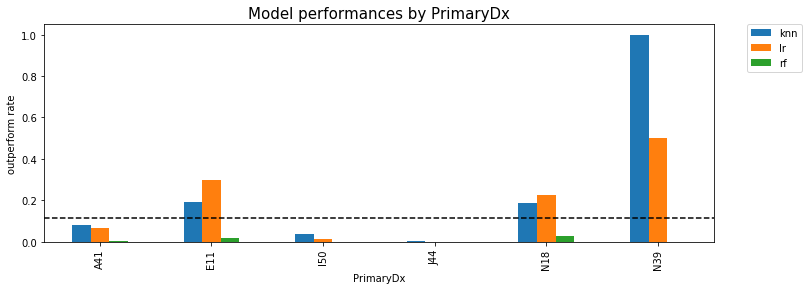

In [871]:
feat1 = 'PrimaryDx'
metrics = ['knn','lr','rf']

knn_avg = preds['knn'].mean()
preds.groupby([feat1])[metrics].mean().plot(kind='bar',figsize=(12,4))
plt.ylabel('outperform rate')
plt.title('Model performances by {}'.format(feat1),size=15)
plt.axhline(y=knn_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

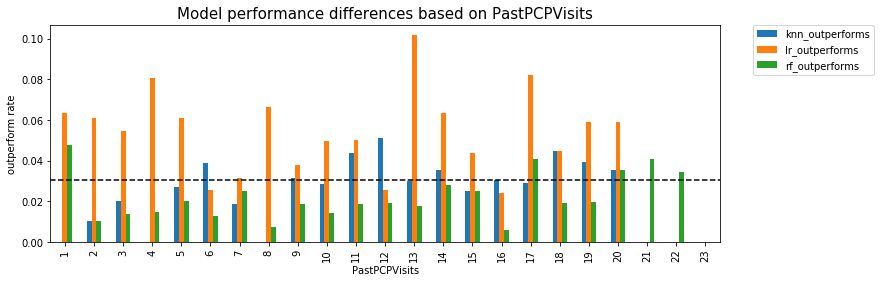

In [872]:
feat1 = 'PastPCPVisits'
metrics = ['knn_outperforms','lr_outperforms','rf_outperforms']

knn_avg = preds['knn_outperforms'].mean()
preds.groupby([feat1])[metrics].mean().plot(kind='bar',figsize=(12,4))
plt.ylabel('outperform rate')
plt.title('Model performance differences based on {}'.format(feat1),size=15)
plt.axhline(y=pop_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Stacking models

Use output of these models to train an aggregator model that will make predictions for the output based on the predictions the previous models made.

I'll need to set up a cross validation rig that will allow these models to predict out-of-fold to be able to reuse the training data for a level 2 model. 

In [873]:
preds_test = pd.DataFrame(y_test)
preds_test['knn'] = knn_pred
preds_test['rf'] = rf_pred
preds_test['lr'] = lr_pred

In [874]:
preds_test.head()

,<=30Days,knn,rf,lr
AdmitDate,,,,
2016-01-03,0.0,0.0,0.0,0.0
2016-05-07,1.0,0.0,0.0,0.0
2016-01-14,0.0,0.0,0.0,0.0
2016-10-26,1.0,0.0,0.0,0.0
2016-08-10,0.0,0.0,0.0,0.0


In [875]:
stack_X_test = preds_test.drop('<=30Days',axis=1)
stack_y_test = preds_test['<=30Days']

In [881]:
lr_stack = LogisticRegression()
stack_score = cross_val_score(lr_stack,stack_X_test,stack_y_test,cv=10)

In [882]:
stack_score.mean()

0.79512161028795081

In [884]:
lr_stack.fit(stack_X_test,stack_y_test)
lr_stack_pred = lr_stack.predict(stack_X_test)

In [885]:
confusion_matrix(stack_y_test,lr_stack_pred)

array([[2096,  163],
       [ 433,  246]])

#### Ideas for next steps again

1. create month feature - hypothesis winter would bring more readmits. possibly make it ordinal? summer = 1, fall+spring = 2, winter = 3
    - binning doesn't seem necessary, but this feature may be helpful
2. look into combination of primary 2ndary dignoses
    - will create a very sparse dataset when onehot encoded
3. bin ages?
    - pass - PCA instead
4. bin pcpvisits?
    - pass - PCA instead
5. drop gender?
    - pass - rf indicated it was an important feature
6. find out what the diagnoses actually are, infer..
    - what next? 

#### Believe I was going about this the wrong way

I was looking at the characteristics of the readmission trying to predict it when I should have flagged the first visit as __will_be_readmitted__

In [ ]:
full_orig[['WillBeReadmitted']] = full_orig[full_orig['Readmitted'] == 1].groupby('Patient').shift(-1)[['<=30Days']].fillna('')


Spot check

In [ ]:
full_orig[full_orig['Patient'] == 'fc443307-b9d7-4a74-8ac5-314aa1b0803a']

I don't know much about diagnoses but I expected the distributions by gender to be different.

In [ ]:
for col in Dx_cols:
    #bins = full[col].unique().shape[0]
    full_orig.groupby(['Gender'])[col].value_counts().unstack().plot(kind='bar',figsize=(12,4))
    plt.title('Distribution of {} by Gender'.format(col),size=15)
    plt.xlabel('dx')
    plt.ylabel('count')
    plt.figure()

My hypothesis would be that having certain combinations of diagnoses would indicate worse conditions than others, so graph the combinations here by choosing the features to combine.

The first indicates to me that generally J44 is worse than other PrimaryDxs

In [ ]:
feat1 = 'PrimaryDx'
feat2 = 'Dx2'
pop_avg = full_orig['<=30Days'].mean()
full_orig.groupby([feat1,feat2])['<=30Days'].mean().unstack().plot(kind='bar',figsize=(12,4))
plt.ylabel('readmit rate')
plt.title('Readmit Rate based on combination of {} and {}'.format(feat1,feat2),size=15)
plt.axhline(y=pop_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
feat1 = 'PrimaryDx'
feat2 = 'Dx3'
pop_avg = full_orig['<=30Days'].mean()
full_orig.groupby([feat1,feat2])['<=30Days'].mean().unstack().plot(kind='bar',figsize=(12,4))
plt.ylabel('readmit rate')
plt.title('Readmit Rate based on combination of {} and {}'.format(feat1,feat2),size=15)
plt.axhline(y=pop_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
feat1 = 'Dx2'
feat2 = 'Dx3'
pop_avg = full_orig['<=30Days'].mean()
full_orig.groupby([feat1,feat2])['<=30Days'].mean().unstack().plot(kind='bar',figsize=(12,4))
plt.ylabel('readmit rate')
plt.title('Readmit Rate based on combination of {} and {}'.format(feat1,feat2),size=15)
plt.axhline(y=pop_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Combos of PrimaryDx, Dx2, Dx3

Perhaps this is a bad idea. I'll be able to tell once I add run it through a model.

In [ ]:
full_orig['PrimaryDx_Dx2'] = full_orig['PrimaryDx']+full_orig['Dx2']
full_orig['PrimaryDx_Dx3'] = full_orig['PrimaryDx']+full_orig['Dx3']
full_orig['Dx2_Dx3'] = full_orig['Dx2']+full_orig['Dx3']

#### Bin/PCA Ages/PCPVisits

After getting a refresher on binning continuous variables, I'm more inclined to do PCA on PastPCPVisits and Age than to bin each. 

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
a = pca.fit_transform(full_orig[['PastPCPVisits','Age','LOS']])

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca.components_

#### Create previous diagnoses fields

Taking a step back and thinking about the data the way it is formatted, I can only predict a readmission based on that admit's details. What I imagine would influence a future admit is also the past admission's PrimaryDx, Dx2, and Dx3.

In [ ]:
full_orig[['PrevPrimaryDx','PrevDx2','PrevDx3']] = full_orig[full_orig['Readmitted'] == 1].groupby('Patient').transform('shift')[['PrimaryDx','Dx2','Dx3']].fillna('')

Spot check a patient

In [ ]:
full_orig[full_orig['Patient'] == 'fc443307-b9d7-4a74-8ac5-314aa1b0803a']

#### Month Admit

Not as big of a difference between months as I thought. Still will include, perhaps certain ailments arise in certain months and this feature will help distinguish when they're more concerning.

__J44__ is more prevalent in the winter months

In [ ]:
full_orig['MonthAdmit'] = full_orig['AdmitDate'].apply(lambda x: x.month)

In [ ]:
full_orig.groupby(['MonthAdmit'])['<=30Days'].mean().plot(kind='bar',figsize=(12,4))
plt.ylabel('readmit rate')
plt.title('Readmit Rate based on {}'.format(feat1),size=15)
plt.axhline(y=pop_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
feat1 = 'MonthAdmit'
feat2 = 'PrimaryDx'
pop_avg = full_orig['<=30Days'].mean()
full_orig.groupby([feat1,feat2])['<=30Days'].mean().unstack().plot(kind='bar',figsize=(12,4))
plt.ylabel('readmit rate')
plt.title('Readmit Rate based on combination of {} and {}'.format(feat1,feat2),size=15)
plt.axhline(y=pop_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
Dxs_summarized['J44']

#### Investigate diagnoses

[Top 25 Griatric ICD-10 Codes](http://htpnmarketing.com/icd10/wp-content/uploads/sites/17/2015/07/Copy-of-Top-25-Geriatric-ICD-9-to-ICD-10.pdf)

[Webapp to query simple info](https://clin-table-search.lhc.nlm.nih.gov/apidoc/icd10cm/v3/doc.html)

In [ ]:
import requests
import json
from pprint import pprint
import pickle

In [ ]:
unique_Dx = []
for col in Dx_cols:
    for Dx in full_orig[col].unique():
        unique_Dx.append(Dx)

In [ ]:
print('There are {} unique Dxs in the dataset'.format(len(unique_Dx)))
unique_Dx = [Dx for Dx in unique_Dx if len(Dx) == 3]

In [ ]:
def get_icd(Dxs):
    Dxs_info = {}
    for Dx in Dxs:
        sample = 'https://clin-table-search.lhc.nlm.nih.gov/api/icd10cm/v3/search?sf=code,name&terms={}'.format(Dx)
        req = requests.get(sample)
        Dxs_info[Dx] = json.loads(req.text)
    return Dxs_info

Dxs_info = get_icd(unique_Dx)

#### Summarize manually or with word counts

Could summarize with word counts. Would need to lowercase and remove stopwords and concat each of the list of descriptions together.

Since only 30, just manually summarize for now.

In [ ]:
Dxs_info['A41']

In [ ]:
Dxs_summarized = {}
for Dx in Dxs_info.keys():
    pprint(Dxs_info[Dx][3])
    Dxs_summarized[Dx] = input('What is the ailment?')

#### Manual Summary:

{'A41': 'Sepsis',
 'E11': 'diabetes mellitus',
 'E56': 'Vitamin deficiency',
 'E86': 'Dehydration',
 'F03': 'dementia',
 'F05': 'Delirium',
 'F19': 'Drug abuse',
 'G31': 'Degeneration of nervous system',
 'G89': 'Chronic Pain',
 'H53': 'Visual discomfort',
 'H91': 'Hearing loss',
 'I10': 'hypertension',
 'I50': 'Heart Failure',
 'I51': 'heart disease',
 'J18': 'Pneumonia',
 'J44': 'COPD',
 'J45': 'asthma',
 'M54': 'Radiculopathy/Panniculitis/Sciatica',
 'N18': 'Chronic kidney disease',
 'N39': 'Urinary incontinence',
 'R05': 'cough',
 'R26': 'abnormalities of gait and mobility',
 'R39': 'Urgency of urination',
 'R41': 'Cognitive functions and awareness symptoms',
 'R51': 'headache',
 'T88': 'Anesthesia Complication',
 'W19': 'Fall'}

In [ ]:
Dxs_summarized